In [141]:
%matplotlib inline

import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model
from sklearn import neural_network
from sklearn import svm
from util import generate_polynomial_data
import matplotlib.pyplot as plt
import plot_helpers
from sklearn import preprocessing
import random
import math
from sklearn import datasets



def sigmoid(x):
    return 1/(1+ np.exp(-x))

def sigmoid_derivative(x):
    return x * (1.0 - x)

def squared_loss(y, y_pred):
    x = mean_squared_error(y, y_pred)**0.5
    return x

def abs_loss(y, y_pred):
    x = mean_absolute_error(y, y_pred)
    return x

def generate_function(f, n):
    X = np.random.rand(n,1)
    X = (X*2)-1
    Y = f(X)
    Y = [y for [y] in Y]
    return (X,Y)

def generate_3dfunction(f, n):
    X = np.random.rand(n,2)
    n = X.shape[0]
    Y = []
    for i in range(n):
        Y.append(f(X[i,0],X[i,1]))
    Y = np.asarray(Y)
    #Y = [y for [y] in Y]
    return (X,Y)

def Ackley(x,y):
    return (-20*math.exp(-0.2*(0.5*((1/1000*x)**2+(1/1000*y)**2)**0.5)) - math.exp(0.5*(math.cos(2*math.pi*x) + math.cos(2*math.pi*y)))+ math.e + 20)

X:  (2000, 1) <class 'numpy.ndarray'>
Y:  (2000,) <class 'numpy.ndarray'>


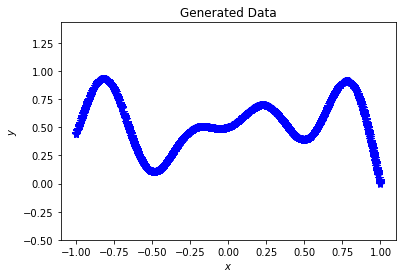

In [142]:
#Generate Data


n = 2000 #number of samples
#f = lambda x: 10*(x-0.5)**3 + x**0.5
f = lambda x: (np.sin(10*x) + np.cos(2*x))*x

#X, Y = generate_3dfunction(Ackley, n)
X, Y = generate_function(f, n)
Y = Y/(max(abs(max(Y)),abs(min(Y))))
Y = (Y - min(Y))/2
Y = np.asarray(Y)
print('X: ', X.shape, type(X))
print('Y: ', Y.shape, type(Y))

limit = int(99*n/100)

X_test = X[:limit]
Y_test = Y[:limit]
X_train = X[limit:]
Y_train = Y[limit:]
Y_train = [[x] for x in Y_train]
Y_train = np.asarray(Y_train)
# Plot Data
fig = plt.subplot(111);
plot_opts = {'x_label': '$x$', 'y_label': '$y$', 'title': 'Generated Data', 'y_lim': [np.min(Y)-0.5, np.max(Y)+0.5]}
plot_helpers.plot_data(X[:, 0], Y, fig=fig, options=plot_opts)

# Normal regressions

In [118]:
#regress

#reg = linear_model.LinearRegression()
reg = neural_network.MLPRegressor(hidden_layer_sizes=(100, 100))
#reg = svm.SVR(kernel='linear')
reg.fit(X_train, Y_train)
Y_pred = reg.predict(X_test)
acc = squared_loss(Y_test, Y_pred)
print(acc)
w = reg.coefs_
#w = reg.get_params
#print(w)

0.17740381312029702


/home/gabriel/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


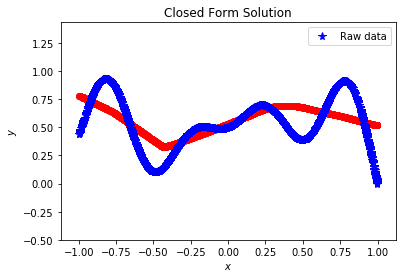

In [119]:
# Plot closed form solution
fig = plt.subplot(111)
plot_opts = {'x_label': '$x$', 'y_label': '$y$', 'title': 'Closed Form Solution', 'legend': True,
             'y_lim': [np.min(Y)-0.5, np.max(Y)+0.5]}

plot_helpers.plot_data(X_test[:, 0], Y_test, fig=fig, options=plot_opts)
#plot_helpers.plot_data(X_test[:, 0], Y_pred, fig=fig, options=plot_opts)
plt.scatter(X_test[:,0], Y_pred, color='red')
#plot_helpers.plot_fit(X, w, fig=fig, options=plot_opts)

# Own neural net

In [120]:
class NeuralNetwork:
    def __init__(self, x, y, n2):
        self.input      = x
        self.weights1   = 2*np.random.rand(self.input.shape[1],n2)-1
        self.y          = y
        self.weights2   = 2*np.random.rand(n2, 1)-1
        self.output     = np.zeros(self.y.shape)

    def feedforward(self):
        self.layer1 = sigmoid(np.dot(self.input, self.weights1))
        self.output = sigmoid(np.dot(self.layer1, self.weights2))

    def backprop(self):
        # application of the chain rule to find derivative of the loss function with respect to weights2 and weights1
        d = (2*(self.y - self.output) * sigmoid_derivative(self.output))
        d_weights2 = np.dot(self.layer1.T, d)
        d_weights1 = np.dot(self.input.T,  (np.dot(d, self.weights2.T) * sigmoid_derivative(self.layer1)))
        # update the weights with the derivative (slope) of the loss function
        self.weights1 += preprocessing.normalize(d_weights1)
        self.weights2 += preprocessing.normalize(d_weights2)

In [121]:
nn = NeuralNetwork(X_train,Y_train, 100)

print("error:")
for i in range(10000):
    nn.feedforward()
    nn.backprop()
    if i % 1000 == 0:
        print(squared_loss(Y_train, nn.output))
    
    

print("final error: \n", squared_loss(Y_train, nn.output))
#for item_a, item_b, item_z in zip(y, nn.output, y-nn.output):
#    print(item_a, item_b, item_z)

error:
0.3410509175388122
0.515204479506114
0.515204479506114
0.515204479506114
0.515204479506114
0.515204479506114
0.515204479506114
0.515204479506114
0.515204479506114
0.515204479506114
final error: 
 0.515204479506114


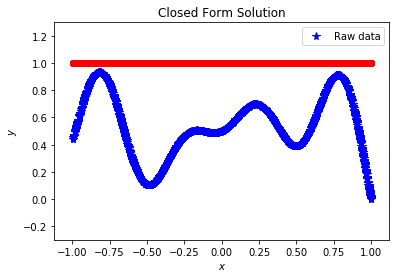

In [122]:
# Plot closed form solution
nn.input = X_test
nn.feedforward()
Y_pred = nn.output

fig = plt.subplot(111)
plot_opts = {'x_label': '$x$', 'y_label': '$y$', 'title': 'Closed Form Solution', 'legend': True,
             'y_lim': [-0.3, 1.3]}

plot_helpers.plot_data(X_test[:, 0], Y_test, fig=fig, options=plot_opts)
#plot_helpers.plot_data(X_test[:, 0], Y_pred, fig=fig, options=plot_opts)
plt.scatter(X_test[:,0], Y_pred, color='red')
#plot_helpers.plot_fit(X, w, fig=fig, options=plot_opts)

# Simulated Annealing

In [123]:
class NeuralNetwork2:
    def __init__(self, x, y, n2):
        self.input      = x
        self.weights1   = 2*np.random.rand(self.input.shape[1],n2)-1
        self.y          = y
        self.weights2   = 2*np.random.rand(n2, 1)-1
        self.output     = np.zeros(self.y.shape)

    def feedforward(self):
        self.layer1 = sigmoid(np.dot(self.input, self.weights1))
        self.output = sigmoid(np.dot(self.layer1, self.weights2))

In [124]:
nn = NeuralNetwork2(X_train,Y_train, 1000)


nn.feedforward()
temp = 1
energy = squared_loss(Y_train, nn.output)

old_energy = 1000
old_weights1 = None
old_weights2 = None

run_length = 10**4

for i in range(run_length):
    if i % (run_length/10) == 0:
        print(i/(run_length/10), ' : ', temp, energy)
    temp *= ((run_length/10)-1)/(run_length/10)
    old_energy = energy
    old_weights1 = nn.weights1[:]
    old_weights2 = nn.weights2[:]
    vec1 = 2*np.random.rand(nn.weights1.shape[0], nn.weights1.shape[1])-1
    vec2 = 2*np.random.rand(nn.weights2.shape[0], nn.weights2.shape[1])-1
    scale_factor = 1/(10-temp)
    nn.weights1 = nn.weights1 + vec1*scale_factor
    nn.weights2 = nn.weights2 + vec2*scale_factor
    nn.feedforward()
    energy = mean_squared_error(Y_train, nn.output)**0.5
    energy = energy + abs(np.linalg.norm(nn.weights1) + np.linalg.norm(nn.weights2))/50000
    if energy < old_energy:
        #print(temp, energy)
        continue
    if energy >= old_energy :
        if random.random() >= temp:
            nn.weights1 = old_weights1[:]
            nn.weights2 = old_weights2[:]
            energy = old_energy
            
        #print(energy) 
    
    

print("final error: \n", energy)
nn.feedforward()

0.0  :  1 0.5968587109026231
1.0  :  0.3676954247709635 0.22735179276334158
2.0  :  0.1351999253974994 0.24729626625385995
3.0  :  0.04971239399803625 0.2627543460920047
4.0  :  0.018279019827489446 0.24946801047572498
5.0  :  0.006721111959865607 0.22354900431887706
6.0  :  0.00247132211701599 0.22392935954444737
7.0  :  0.0009086938355620674 0.21772613282675246
8.0  :  0.00033412256585375113 0.21465208973165636
9.0  :  0.0001228553387771593 0.21333611268062352
final error: 
 0.21119351311701415


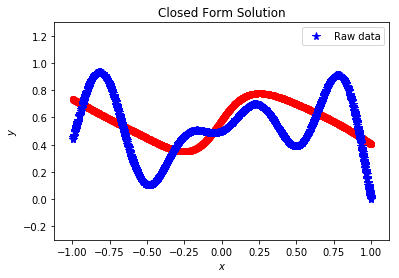

In [125]:
# Plot closed form solution
nn.input = X_test
nn.feedforward()
Y_pred = nn.output

fig = plt.subplot(111)
plot_opts = {'x_label': '$x$', 'y_label': '$y$', 'title': 'Closed Form Solution', 'legend': True,
             'y_lim': [-0.3, 1.3]}

plot_helpers.plot_data(X_test[:, 0], Y_test, fig=fig, options=plot_opts)
#plot_helpers.plot_data(X_test[:, 0], Y_pred, fig=fig, options=plot_opts)
plt.scatter(X_test[:,0], Y_pred, color='red')
#plot_helpers.plot_fit(X, w, fig=fig, options=plot_opts)

# Mulitylayer SA

In [143]:
class NeuralNetwork3:
    def __init__(self, x, y, n, l):
        self.input      = x
        self.y          = y
        self.width      = n
        self.depth      = l
        m = self.input.shape[1]
        
        self.layer      = []
        self.layer.append(x)
        for i in range(1,l):
            self.layer.append(np.zeros((m,n)))
        self.layer.append(np.zeros(self.y.shape))
        self.output = self.layer[l]
        
        self.weights    = []
        self.weights.append(2*np.random.rand(m, n)-1)
        for i in range(1,l-1):
            self.weights.append(2*np.random.rand(n,n)-1)
        self.weights.append(2*np.random.rand(n,1)-1)

    def feedforward(self):
        l = self.depth
        for i in range(1,l+1):
            self.layer[i] = sigmoid(np.dot(self.layer[i-1], self.weights[i-1]))
        self.output = self.layer[l]

In [148]:
#tuning screws

temp = 1
run_length = 10**5
reg_lambda = 10**2
num_nodes = 100
num_layers = 3


#initialization

nn = NeuralNetwork3(X_train, Y_train, num_nodes, num_layers)
nn.feedforward()
#energy = squared_loss(Y_train, nn.output)
energy = abs_loss(Y_train, nn.output)
old_energy = 1000
old_weights = None
old_reg_energy = 1000
reg_energy = energy

#training

for i in range(run_length):
    
    #print only distance error 
    if i % (run_length/10) == 0:
        print(i/(run_length/10), ' : ', temp, energy, mean_squared_error(Y_train, nn.output)**0.5)
        
    #change and store variables
    temp *= ((run_length/10)-1)/(run_length/10)
    old_energy = energy
    old_weights = nn.weights[:]
    old_reg_energy = reg_energy
    norm = 0
    scale_factor = 1/(10-temp)
    
    for i in range(0, nn.depth):
        vec = 2*np.random.rand(nn.weights[i].shape[0], nn.weights[i].shape[1])-1
        nn.weights[i] = nn.weights[i] + vec*scale_factor
        norm = norm + abs(np.linalg.norm(nn.weights[i]))
    nn.feedforward()
    #energy = mean_squared_error(Y_train, nn.output)**0.5
    energy = abs_loss(Y_train, nn.output)
    reg_energy = energy + norm/reg_lambda
    if reg_energy < old_reg_energy:
        continue
    if reg_energy >= old_reg_energy :
        if random.random() >= temp:
            nn.weights = old_weights[:]
            reg_energy = old_reg_energy 
            energy = old_energy

#output    

print("final error: \n", energy)
nn.feedforward()

0.0  :  1 0.45505756049918655 0.4890209109456764
1.0  :  0.3678610464329692 0.2953693416679296 0.32265226674509534
2.0  :  0.13532174948275888 0.12929684638889874 0.20936333478900304
3.0  :  0.0497796003698677 0.10339159289527677 0.17097636818060083
4.0  :  0.01831197588307456 0.09302752230679523 0.18071326625187417
5.0  :  0.0067362626106031364 0.10385744477943563 0.1387721619138316
6.0  :  0.0024780086129837513 0.11891251327554905 0.1516787398808128
7.0  :  0.0009115628414421125 0.1266142284451554 0.16380351037927324
8.0  :  0.0003353284607423079 0.11871406829721551 0.1811507566102381
9.0  :  0.000123354278467422 0.13013970895268373 0.1683246440479336
final error: 
 0.11408581659595447


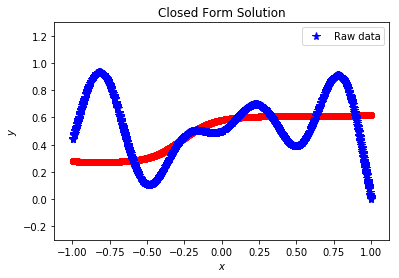

In [149]:
# Plot
nn.layer[0] = X_test[:]
nn.feedforward()
Y_pred = nn.output[:]

fig = plt.subplot(111)
plot_opts = {'x_label': '$x$', 'y_label': '$y$', 'title': 'Closed Form Solution', 'legend': True,
             'y_lim': [-0.3, 1.3]}

plot_helpers.plot_data(X_test[:, 0], Y_test, fig=fig, options=plot_opts)
plt.scatter(X_test[:,0], Y_pred, color='red')